# 02__filter_data

in this notebook, i perform several QC checks of the screen data, and filter the screen data to a set of robustly captured and reliable sgRNAs.

figures in this notebook:
- Fig S5B: scatter plot showing undifferentiated counts across replicates for positive control sgRNAs
- Fig S5C: 2D density plot showing undifferentiated counts vs. day zero counts for scrambled sgRNAs
- Fig 3C: 2D density plot showing undifferentiated counts across replicates for all sgRNAs
- Fig S5D: histogram showing count of TSSs w/ given number of sgRNAs post-filtering
- Fig S5F: count of sgRNAs per biotype after filtering
- Fig S5G: distributions of sgRNA log2 fold changes (from DESeq2) for targeting and scrambled sgRNAs
- Fig 3D: boxplot showing sgRNA log2 fold changes for positive control and scrambled sgRNAs
- Fig S5H: example plot of sgRNA log2 fold changes for positive control SOX17

tables in this notebook:
- Table S2: contains sgRNA results (l2fcs) and filter status, among other metadata

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import sys
import time

from ast import literal_eval
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from enrich_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
data_f = "../../../data/02__screen/01__normalized_counts/Biol_Reps.sgRNA_counts.w_index.txt"

In [4]:
l2fcs_f = "../../../data/02__screen/01__normalized_counts/l2fcs.DESeq2.txt"

## 1. import data

In [5]:
data = pd.read_table(data_f)
print(len(data))
data.head()

111801


,sgRNA,ctrl_status,gene_id,gene_name,transcript_id,transcript_name,transcript_biotype_status,tss_chr_hg38,tss_start_hg38,tss_strand_hg38,...,Pos_Rep1__counts,Pos_Rep2__counts,Neg_Rep1__counts,Neg_Rep2__counts,DZ_Rep1__cpm,DZ_Rep2__cpm,Pos_Rep1__cpm,Pos_Rep2__cpm,Neg_Rep1__cpm,Neg_Rep2__cpm
0,TTGCAAGTGTCTTTAAACTA,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,...,574,769,872,1049,6.374260,9.515495,2.683950,7.813446,5.975173,7.449968
1,ATTGCAAGTGTCTTTAAACT,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,...,1159,482,0,449,3.209212,4.041303,5.414577,4.901161,0.006844,3.192843
2,AGCCAGTATCTTGAAACTAT,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,...,967,700,0,1080,5.380582,6.378442,4.518371,7.113280,0.006844,7.669919
3,TGCCAATAGTTTCAAGATAC,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,...,1145,382,516,584,3.098803,3.665691,5.349229,3.886428,3.538562,4.150696
4,ACAGTAGTGTATCTAAATGG,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,...,2263,679,0,690,8.346894,8.200854,10.567761,6.900186,0.006844,4.902788


In [6]:
l2fcs = pd.read_table(l2fcs_f, sep="\t").reset_index()
l2fcs.columns = ["sgRNA", "baseMean", "l2fc", "l2fcSE", "stat", "pvalue", "padj"]
print(len(l2fcs))
l2fcs.head()

111801


,sgRNA,baseMean,l2fc,l2fcSE,stat,pvalue,padj
0,TTATCTGCATACTTATACAG,412.256020,1.041851,2.839617,0.366898,0.713695,0.987449
1,TATGCTTTATCCACTCCGAC,758.030833,1.009004,0.688290,1.465958,0.142660,0.518996
2,TGAAAGCATAGGATATGGCA,1418.357265,0.103126,0.480260,0.214730,0.829978,0.997096
3,AATGGTAAGTTGCTGCTCAG,1245.173748,-0.285771,0.392330,-0.728394,0.466372,0.897957
4,TAAGCATGCGTGGTATCAAG,997.275096,1.165282,2.578840,0.451863,0.651368,0.974865


## 2. plot normalized gRNA counts

In [7]:
data_cols = ["DZ_Rep1__cpm", "DZ_Rep2__cpm", "Pos_Rep1__cpm", 
             "Pos_Rep2__cpm", "Neg_Rep1__cpm", "Neg_Rep2__cpm"]

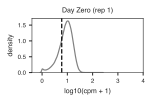

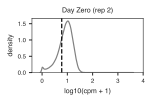

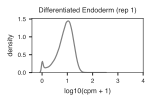

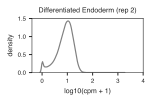

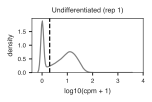

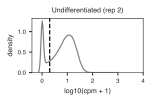

In [8]:
names = ["Day Zero (rep 1)", "Day Zero (rep 2)", "Differentiated Endoderm (rep 1)", "Differentiated Endoderm (rep 2)",
         "Undifferentiated (rep 1)", "Undifferentiated (rep 2)"]
count_threshs = [5, 5, np.nan, np.nan, 1, 1]

c = 1
for col, name, count_thresh in zip(data_cols, names, count_threshs):
    
    fig = plt.figure(figsize=(2, 1))
    ax = sns.distplot(np.log10(data[col]+1), hist=False, bins=15, kde=True, color="gray")
    ax.set_ylabel("density")
    ax.set_xlabel("log10(cpm + 1)")
    ax.set_title(name)
    ax.set_xlim((-0.4, 4))
    if count_thresh != np.nan:
        ax.axvline(x=np.log10(count_thresh+1), linestyle="dashed", color="black")
    plt.show()
    #fig.savefig("FigS5B_%s.pdf" % c, figure="dpi", bbox_inches="tight")
    plt.close()
    c += 1

## 3. join count data with l2fc data

In [9]:
data["scramble_id"] = data.apply(get_scramble_id, axis=1)
data["group_id"] = data.apply(get_group_id, axis=1)

In [10]:
data = data.merge(l2fcs, on="sgRNA")
data.sample(5)

,sgRNA,ctrl_status,gene_id,gene_name,transcript_id,transcript_name,transcript_biotype_status,tss_chr_hg38,tss_start_hg38,tss_strand_hg38,...,Neg_Rep1__cpm,Neg_Rep2__cpm,scramble_id,group_id,baseMean,l2fc,l2fcSE,stat,pvalue,padj
79831,GGGAGCCAGGACACGGATCC,experimental,ENSG00000261241.5_1,RP11-883G14.1,"['ENST00000570245.5_1', 'ENST00000567534.2_1']","['RP11-883G14.1-002', 'RP11-883G14.1-001']",gene_nearby,chr16,50884209,+,...,0.006844,0.007095,none,NC_000016.10:+:50884209,648.330918,12.774119,1.821821,7.011731,2.353867e-12,1.715133e-09
31313,ATTTCTCTCCCTAACAAGTG,experimental,ENSG00000244968.6_1,LIFR-AS1,ENST00000500817.2_1,LIFR-AS1-002,transcript_overlap,chr5,38558795,+,...,16.488193,23.591564,none,NC_000005.10:+:38558795,2233.707704,-0.881040,0.541706,-1.626417,1.038610e-01,4.269865e-01
24990,ACTCTTTGACTCCAAGATAC,experimental,ENSG00000249425.1_1,RP11-502M1.2,ENST00000512652.1_1,RP11-502M1.2-001,intergenic,chr4,160539254,+,...,0.068444,0.007095,none,NC_000004.12:+:160539254,99.710471,5.456170,1.871261,2.915773,3.548089e-03,3.226049e-02
36342,TGGAGGCGCGGCTGCTCTCT,experimental,ENSG00000234817.2_2,RP3-400B16.1,ENST00000427049.2_1,RP3-400B16.1-001,promoter_overlap,chr6,4136071,+,...,1.355194,11.614854,none,NC_000006.12:+:4136071,1051.293228,0.310650,1.189302,0.261204,7.939355e-01,9.962690e-01
40675,GAACCCAGACAAAAGGGCCT,experimental,ENSG00000227481.1_1,RP11-89N17.2,ENST00000455149.1_1,RP11-89N17.2-001,intergenic,chr7,33732064,-,...,0.006844,6.279258,none,NC_000007.14:-:33732064,1062.036992,1.876211,2.511889,0.746932,4.551045e-01,8.911029e-01


In [11]:
# flip l2fcs (they are backwards coming out of DESeq2)
data["l2fc"] = -data["l2fc"]

In [12]:
len(data)

111801

## 4. plot correlations across undifferentiated replicates for + control sgRNAs

In [13]:
data_ctrls = data[data["ctrl_status"] == "control"]

<Figure size 144x144 with 0 Axes>

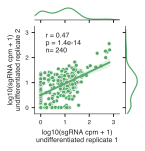

In [14]:
fig = plt.figure(figsize=(2, 2))

no_nan = data_ctrls[(~pd.isnull(data_ctrls["Neg_Rep1__cpm"])) & (~pd.isnull(data_ctrls["Neg_Rep2__cpm"]))]
no_nan["Neg_Rep1__cpm"] = np.log10((no_nan["Neg_Rep1__cpm"]+1))
no_nan["Neg_Rep2__cpm"] = np.log10((no_nan["Neg_Rep2__cpm"]+1))

g = sns.jointplot(data=no_nan, x="Neg_Rep1__cpm", y="Neg_Rep2__cpm", color=sns.color_palette()[2], kind="reg",
                   joint_kws={"scatter_kws": {"s": 15, "alpha": 1, "linewidths": 0.5, 
                              "edgecolors": "white"}},
                   marginal_kws={"bins": 20, "hist": False, "kde": True}, size=2, space=0.5)

g.ax_joint.set_xlim(-0.25, 3.25)
g.ax_joint.set_ylim(-0.25, 3.25)

g.ax_joint.set_xticks([0, 1, 2, 3])
g.ax_joint.set_yticks([0, 1, 2, 3])

g.set_axis_labels("log10(sgRNA cpm + 1)\nundifferentiated replicate 1", 
                  "log10(sgRNA cpm + 1)\nundifferentiated replicate 2")

# annotate number of guides above thresh
r, p = stats.spearmanr(no_nan["Neg_Rep1__cpm"], no_nan["Neg_Rep2__cpm"])
g.ax_joint.text(0.2, 3, "r = %s\np = %s\nn= %s" % ((round(r, 2), round(p, 15), len(no_nan))), 
                ha="left", va="top", fontsize=fontsize)

plt.show()
g.savefig("FigS5B_1.pdf", dpi="figure", bbox_inches="tight")
plt.close()

In [15]:
data_ctrls = data[data["gene_name"].isin(["FOXA2", "SOX17"])]

<Figure size 144x144 with 0 Axes>

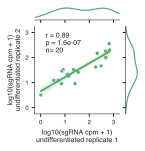

In [16]:
fig = plt.figure(figsize=(2, 2))

no_nan = data_ctrls[(~pd.isnull(data_ctrls["Neg_Rep1__cpm"])) & (~pd.isnull(data_ctrls["Neg_Rep2__cpm"]))]
no_nan["Neg_Rep1__cpm"] = np.log10((no_nan["Neg_Rep1__cpm"]+1))
no_nan["Neg_Rep2__cpm"] = np.log10((no_nan["Neg_Rep2__cpm"]+1))

g = sns.jointplot(data=no_nan, x="Neg_Rep1__cpm", y="Neg_Rep2__cpm", color=sns.color_palette()[2], kind="reg",
                   joint_kws={"scatter_kws": {"s": 15, "alpha": 1, "linewidths": 0.5, 
                              "edgecolors": "white"}},
                   marginal_kws={"bins": 20, "hist": False, "kde": True}, size=2, space=0.5)

g.ax_joint.set_xlim(-0.25, 3.25)
g.ax_joint.set_ylim(-0.25, 3.25)

g.ax_joint.set_xticks([0, 1, 2, 3])
g.ax_joint.set_yticks([0, 1, 2, 3])

g.set_axis_labels("log10(sgRNA cpm + 1)\nundifferentiated replicate 1", 
                  "log10(sgRNA cpm + 1)\nundifferentiated replicate 2")

# annotate number of guides above thresh
r, p = stats.spearmanr(no_nan["Neg_Rep1__cpm"], no_nan["Neg_Rep2__cpm"])
g.ax_joint.text(0.2, 3, "r = %s\np = %s\nn= %s" % ((round(r, 2), round(p, 8), len(no_nan))), 
                ha="left", va="top", fontsize=fontsize)

plt.show()
g.savefig("FigS5B_2.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 5. remove noisy sgRNAs -- based on scrambled guides day zero counts
set a day zero cpm cutoff in both replicates with the goal of removing most negative control outliers -- effective "signal to noise" cutoff.

<Figure size 144x144 with 0 Axes>

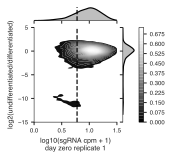

In [19]:
fig = plt.figure(figsize=(2, 2))

no_nan = data[(~pd.isnull(data["DZ_Rep1__cpm"])) & (~pd.isnull(data["l2fc"]))]
no_nan["DZ_Rep1__cpm"] = np.log10((no_nan["DZ_Rep1__cpm"]+1))
scram = no_nan[no_nan["ctrl_status"] == "scramble"]
g = sns.jointplot(data=scram, x="DZ_Rep1__cpm", y="l2fc", cmap="Greys_r", kind="kde",
                  joint_kws={"shade": True, "shade_lowest": False, "n_levels": 30, "cbar": True},
                  marginal_kws={"color": "black"},
                  size=2, space=0.5)

## move color bar
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = g.ax_joint.get_position()
pos_marg_x_ax = g.ax_marg_x.get_position()
# reposition the joint ax so it has the same width as the marginal x ax
g.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# reposition the colorbar using new x positions and y positions of the joint ax
g.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

g.ax_joint.set_xlim((0, 1.5))
g.ax_joint.set_ylim((-15, 5))
g.ax_joint.axvline(x=np.log10(5+1), color="black", linestyle="dashed")
g.ax_marg_x.axvline(x=np.log10(5+1), color="black", linestyle="dashed")

g.set_axis_labels("log10(sgRNA cpm + 1)\nday zero replicate 1", 
                  "log2(undifferentiated/differentiated)")

plt.show()
g.savefig("FigS5C_1.pdf", dpi="figure", bbox_inches="tight")
plt.close()

<Figure size 144x144 with 0 Axes>

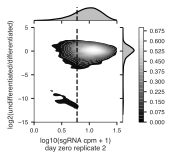

In [20]:
fig = plt.figure(figsize=(2, 2))

no_nan = data[(~pd.isnull(data["DZ_Rep2__cpm"])) & (~pd.isnull(data["l2fc"]))]
no_nan["DZ_Rep2__cpm"] = np.log10((no_nan["DZ_Rep2__cpm"]+1))
scram = no_nan[no_nan["ctrl_status"] == "scramble"]
g = sns.jointplot(data=scram, x="DZ_Rep2__cpm", y="l2fc", cmap="Greys_r", kind="kde",
                  joint_kws={"shade": True, "shade_lowest": False, "n_levels": 30, "cbar": True},
                  marginal_kws={"color": "black"},
                  size=2, space=0.5)

## move color bar
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = g.ax_joint.get_position()
pos_marg_x_ax = g.ax_marg_x.get_position()
# reposition the joint ax so it has the same width as the marginal x ax
g.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# reposition the colorbar using new x positions and y positions of the joint ax
g.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

g.ax_joint.set_xlim((0, 1.5))
g.ax_joint.set_ylim((-15, 5))
g.ax_joint.axvline(x=np.log10(5+1), color="black", linestyle="dashed")
g.ax_marg_x.axvline(x=np.log10(5+1), color="black", linestyle="dashed")

g.set_axis_labels("log10(sgRNA cpm + 1)\nday zero replicate 2", 
                  "log2(undifferentiated/differentiated)")

plt.show()
g.savefig("FigS5C_2.pdf", dpi="figure", bbox_inches="tight")
plt.close()

In [21]:
data_filt = data[(data["DZ_Rep1__cpm"] >= 5) & (data["DZ_Rep2__cpm"] >= 5)]
len(data_filt)

76091

## 6. remove noisy sgRNAs -- that are only captured in one undifferentiated replicate

we can see from the histograms above that many sgRNAs are not captured at all in a given undifferentiated replicate. this will add a ton of noise to our analysis -- so we will filter to only capture sgRNAs that are in both replicates, and a cpm of 1 perfectly separates the bimodal histogram

<Figure size 144x144 with 0 Axes>

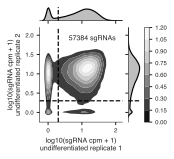

In [22]:
fig = plt.figure(figsize=(2, 2))

no_nan = data_filt[(~pd.isnull(data_filt["Neg_Rep1__cpm"])) & (~pd.isnull(data["Neg_Rep2__cpm"]))]
no_nan["Neg_Rep1__cpm"] = np.log10((no_nan["Neg_Rep1__cpm"]+1))
no_nan["Neg_Rep2__cpm"] = np.log10((no_nan["Neg_Rep2__cpm"]+1))
g = sns.jointplot(data=no_nan, x="Neg_Rep1__cpm", y="Neg_Rep2__cpm", cmap="Greys_r", kind="kde",
                  joint_kws={"shade": True, "shade_lowest": False, "n_levles": 15, "cbar": True},
                  marginal_kws={"color": "black"},
                  size=2, space=0.5)

## move color bar
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = g.ax_joint.get_position()
pos_marg_x_ax = g.ax_marg_x.get_position()
# reposition the joint ax so it has the same width as the marginal x ax
g.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# reposition the colorbar using new x positions and y positions of the joint ax
g.fig.axes[-1].set_position([.83, pos_joint_ax.y0, 2, pos_joint_ax.height])


g.ax_joint.axhline(y=np.log10(1+1), color="black", linestyle="dashed")
g.ax_joint.axvline(x=np.log10(1+1), color="black", linestyle="dashed")
g.ax_marg_y.axhline(y=np.log10(1+1), color="black", linestyle="dashed")
g.ax_marg_x.axvline(x=np.log10(1+1), color="black", linestyle="dashed")
g.ax_joint.set_xlim(-0.25, 2.2)
g.ax_joint.set_ylim(-0.25, 2.2)

g.set_axis_labels("log10(sgRNA cpm + 1)\nundifferentiated replicate 1", 
                  "log10(sgRNA cpm + 1)\nundifferentiated replicate 2")

# g.ax_joint.set_xticks([0, 2, 4, 6])
# g.ax_joint.set_yticks([0, 2, 4, 6])

# annotate number of guides above thresh
n = len(data_filt[(data_filt["Neg_Rep1__cpm"] >= 1) & (data_filt["Neg_Rep2__cpm"] >= 1)])
g.ax_joint.text(2, 2, "%s sgRNAs" % (n), ha="right", va="top", fontsize=fontsize)

plt.show()
g.savefig("Fig3C.pdf", dpi="figure", bbox_inches="tight")
plt.close()

In [23]:
data_filt = data_filt[(data_filt["Neg_Rep1__cpm"] >= 1) & (data_filt["Neg_Rep2__cpm"] >= 1)]
len(data_filt)

57384

## 6. plot coverage of guides after filtering

In [24]:
data_filt_cnts = data_filt.groupby(["group_id", "ctrl_status"])["sgRNA"].agg("count").reset_index()
data_tot_cnts = data.groupby(["group_id", "ctrl_status"])["sgRNA"].agg("count").reset_index()
data_cnts = data_tot_cnts.merge(data_filt_cnts, on=["group_id", "ctrl_status"], how="left", 
                                suffixes=("_tot", "_filt"))
data_cnts.head()

,group_id,ctrl_status,sgRNA_tot,sgRNA_filt
0,NC_000001.11:+:100894913,experimental,10,4.0
1,NC_000001.11:+:100995473,experimental,10,8.0
2,NC_000001.11:+:101025906,experimental,8,3.0
3,NC_000001.11:+:101072856,experimental,9,2.0
4,NC_000001.11:+:101081966,experimental,10,7.0


In [25]:
data_cnts.fillna(0, inplace=True)
data_cnts.sample(5)

,group_id,ctrl_status,sgRNA_tot,sgRNA_filt
9225,NC_000018.10:-:48963946,experimental,10,5.0
4265,NC_000008.11:+:121639881,experimental,10,6.0
10346,NC_000022.11:+:36091148,experimental,10,6.0
6264,NC_000012.12:+:54419786,experimental,10,5.0
5212,NC_000010.11:+:42871521,experimental,10,6.0


In [26]:
data_cnts.ctrl_status.value_counts()

experimental    10556
scramble          500
mRNA              272
control            24
Name: ctrl_status, dtype: int64

In [27]:
data_cnts_ns = data_cnts[data_cnts["ctrl_status"] != "scramble"]

In [28]:
n_ov3 = len(data_cnts_ns[data_cnts_ns["sgRNA_filt"] >= 3])
n_tot = len(data_cnts_ns)
p_ov3 = n_ov3/n_tot

print(n_ov3)
print(n_tot)
print(p_ov3)

9771
10852
0.9003870254330999


In [29]:
guide_cov = pd.DataFrame(data_cnts_ns["sgRNA_filt"].value_counts()).reset_index().sort_values(by="index")
guide_cov

,index,sgRNA_filt
9,0.0,128
7,1.0,326
6,2.0,627
4,3.0,1241
2,4.0,1792
0,5.0,2146
1,6.0,2037
3,7.0,1504
5,8.0,754
8,9.0,259


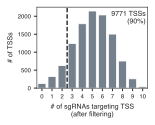

In [30]:
fig = plt.figure(figsize=(2, 1.5))

ax = sns.barplot(data=guide_cov, x="index", y="sgRNA_filt", color="slategray")
ax.set_xlabel("# of sgRNAs targeting TSS\n(after filtering)")
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax.set_ylabel("# of TSSs")
ax.set_xlim(-0.5, 10.5)

ax.axvline(x=2.5, linestyle="dashed", color="black")
ax.text(10.3, 2150, "%s TSSs\n(%s%%)" % (n_ov3, round(p_ov3*100)), ha="right", va="top")
fig.savefig("FigS5D.pdf", dpi="figure", bbox_inches="tight")

## 7. remove any targeted TSSs with < 3 sgRNAs that meet above filters
but keep all scrambled negative controls

In [31]:
## get group_ids that have >= 3 guides
good_grps = data_cnts_ns[data_cnts_ns["sgRNA_filt"] >= 3]["group_id"]
len(good_grps)

9771

In [32]:
# limit targeted tsss to those that have >= 3 guides meeting filters
data_filt_ns = data_filt[data_filt["ctrl_status"] != "scramble"]
data_filt_s = data_filt[data_filt["ctrl_status"] == "scramble"]
data_filt_ns = data_filt_ns[data_filt_ns["group_id"].isin(good_grps)]
data_filt = data_filt_ns.append(data_filt_s)
len(data_filt)

55804

## 8. check control and biotype counts in this filtered set

In [33]:
data_filt.ctrl_status.value_counts()

experimental    51493
scramble         2690
mRNA             1483
control           138
Name: ctrl_status, dtype: int64

In [34]:
data_filt.drop_duplicates(subset="group_id").ctrl_status.value_counts()

experimental    9493
scramble         492
mRNA             255
control           23
Name: ctrl_status, dtype: int64

In [35]:
tmp = data_filt[data_filt["ctrl_status"] == "experimental"].drop_duplicates(subset="group_id")
tmp.transcript_biotype_status.value_counts()

transcript_overlap    3587
intergenic            2893
promoter_overlap      2753
gene_nearby            180
multi-targeting         80
Name: transcript_biotype_status, dtype: int64

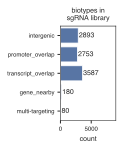

In [36]:
fig = plt.figure(figsize=(1, 1.75))

order = ["intergenic", "promoter_overlap", "transcript_overlap", "gene_nearby", "multi-targeting"]
ax = sns.countplot(data=tmp, y="transcript_biotype_status", order=order, color=sns.color_palette()[0])

for p in ax.patches:
    w = p.get_width()
    y = p.get_y()
    h = p.get_height()
    
    ax.text(w + 100, y + h/2, int(w), ha="left", va="center", fontsize=fontsize) 
    
plt.xlim((0,9000))
plt.ylabel("")
plt.title("biotypes in\nsgRNA library")
fig.savefig("FigS5F_2.pdf", dpi="figure", bbox_inches="tight")

## 8. check distribution of l2fcs for control guides vs. negative control guides

for CRISPhieRmix to work properly, it assumes that the majority of targeting guides do not work or are inefficient at knockdown and will act like negative controls. make sure this is true -- dists overlap

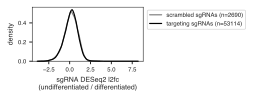

In [37]:
fig = plt.figure(figsize=(2, 1))

scram = data_filt[data_filt["ctrl_status"] == "scramble"]
notscram = data_filt[data_filt["ctrl_status"] != "scramble"]

ax = sns.distplot(scram["l2fc"], hist=False, color="gray", label="scrambled sgRNAs (n=%s)" % len(scram))
sns.distplot(notscram["l2fc"], hist=False, color="black", label="targeting sgRNAs (n=%s)" % len(notscram))
ax.set_xlabel("sgRNA DESeq2 l2fc\n(undifferentiated / differentiated)")
ax.set_ylabel("density")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))
fig.savefig("FigS5G.pdf", dpi="figure", bbox_inches="tight")

negative control guides look identical to targeting guides -- this is good for CRISPhieRmix

## 9. plot enrichment scores of neg ctrl sgRNAs vs pos ctrl sgRNAs

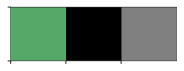

In [38]:
pal = {"control": sns.color_palette()[2], "experimental": "black", "scramble": "gray"}
sns.palplot(pal.values())

8.038002959790843e-05


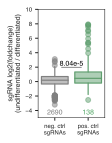

In [39]:
fig = plt.figure(figsize=(1.2, 2))

ax = sns.boxplot(data=data_filt, x="ctrl_status", y="l2fc", order=["scramble", "control"],
                 palette=pal, flierprops=dict(marker='o', markersize=5))
mimic_r_boxplot(ax)
ax.set_xticklabels(["neg. ctrl\nsgRNAs", "pos. ctrl\nsgRNAs"], rotation=0, ha="center",
                   va="top")
ax.set_xlabel("")
ax.set_ylabel("sgRNA log2(foldchange)\n(undifferentiated / differentiated)")
ax.set_ylim(-5, 10)

# calc p-vals b/w dists
vals1 = np.asarray(data_filt[data_filt["ctrl_status"] == "scramble"]["l2fc"])
vals2 = np.asarray(data_filt[data_filt["ctrl_status"] == "control"]["l2fc"])

vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]

u, pval = stats.mannwhitneyu(vals1, vals2, alternative="less", use_continuity=False)
print(pval)
annotate_pval(ax, 0.2, 0.8, 2, 0, 2, pval, fontsize)

for i, x in enumerate(["scramble", "control"]):
    n = len(data_filt[data_filt["ctrl_status"] == x])
    ax.text(i, -4.75, n, color=pal[x], va="bottom", ha="center")

fig.savefig("Fig3D.pdf", bbox_inches="tight", dpi="figure")

### example plot of guide distributions

In [40]:
scram = data_filt[data_filt["ctrl_status"] == "scramble"]

7


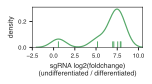

In [41]:
sox17 = data_filt[data_filt["gene_name"] == "SOX17"]
print(len(sox17))

fig = plt.figure(figsize=(2, 0.75))
ax = sns.distplot(sox17["l2fc"], color=pal["control"], rug=True, hist=False, rug_kws={"height": 0.15})
ax.set_ylabel("density")
ax.set_xlabel("sgRNA log2(foldchange)\n(undifferentiated / differentiated)")
ax.set_xlim((-2.5, 10.5))
fig.savefig("FigS5H.pdf", bbox_inches="tight", dpi="figure")

## 10. write file needed for CRISPhieRmix

In [42]:
data_filt = data_filt.merge(data_cnts[["group_id", "sgRNA_filt"]], on="group_id")
len(data_filt)

55804

In [43]:
data_filt["group_id_rd"] = data_filt["transcript_name"] + ";;;" + data_filt["group_id"] + ";;;" + data_filt["ctrl_status"] + ";;;" + data_filt["transcript_biotype_status"] + ";;;" + data_filt["sgRNA_filt"].astype(int).astype(str)

In [44]:
f = "../../../data/02__screen/02__enrichment_data/data_filt.tmp"
data_filt = data_filt[~pd.isnull(data_filt["l2fc"])]
print(len(data_filt))
data_filt.to_csv(f, sep="\t", index=False)

55804


In [45]:
data_filt_grp = data_filt.groupby(["group_id_rd", "ctrl_status"])["sgRNA"].agg("count").reset_index()
data_filt_grp.ctrl_status.value_counts()

experimental    9493
mRNA             255
control           23
Name: ctrl_status, dtype: int64

In [46]:
data_filt.ctrl_status.value_counts()

experimental    51493
scramble         2690
mRNA             1483
control           138
Name: ctrl_status, dtype: int64

## 11. write supplementary file (contains all sgRNA data, not just filtered ones)

In [47]:
data.columns

Index(['sgRNA', 'ctrl_status', 'gene_id', 'gene_name', 'transcript_id',
       'transcript_name', 'transcript_biotype_status', 'tss_chr_hg38',
       'tss_start_hg38', 'tss_strand_hg38', 'tss_type', 'tss_id_hg38',
       'sgRNA_id', 'DZ_Rep1__counts', 'DZ_Rep2__counts', 'Pos_Rep1__counts',
       'Pos_Rep2__counts', 'Neg_Rep1__counts', 'Neg_Rep2__counts',
       'DZ_Rep1__cpm', 'DZ_Rep2__cpm', 'Pos_Rep1__cpm', 'Pos_Rep2__cpm',
       'Neg_Rep1__cpm', 'Neg_Rep2__cpm', 'scramble_id', 'group_id', 'baseMean',
       'l2fc', 'l2fcSE', 'stat', 'pvalue', 'padj'],
      dtype='object')

In [48]:
def filt_status(row):
    if row.DZ_Rep1__cpm >= 5 and row.DZ_Rep2__cpm >= 5:
        if row.Neg_Rep1__cpm >= 1 and row.Neg_Rep2__cpm >= 1:
            if row.ctrl_status != "scramble":
                if row.group_id in list(good_grps):
                    return "filter met"
                else:
                    return "filter not met"
            else:
                return "filter met"
        else:
            return "filter not met"
    else:
        return "filter not met"
    
data["filt_status"] = data.apply(filt_status, axis=1)

In [49]:
supp = data[["sgRNA", "ctrl_status", "gene_name", "gene_id", "transcript_name", "transcript_id", "group_id", 
             "tss_chr_hg38", "tss_start_hg38", "tss_strand_hg38", "tss_type",
             "DZ_Rep1__counts", "DZ_Rep2__counts", "Neg_Rep1__counts", "Neg_Rep2__counts", "Pos_Rep1__counts", 
             "Pos_Rep2__counts", "DZ_Rep1__cpm", "DZ_Rep2__cpm", "Neg_Rep1__cpm", "Neg_Rep2__cpm", "Pos_Rep1__cpm",
             "Pos_Rep2__cpm", "filt_status", "l2fc", "l2fcSE"]]
supp.columns = ["sgRNA", "control_status", "gene_name", "gene_id", "transcript_name", "transcript_id", "tss_id",
                "tss_chr_hg38", "tss_start_hg38", "tss_strand_hg38", "tss_type",
                "DayZero_Rep1__counts", "DayZero_Rep2__counts", "Undiff_Rep1__counts", "Undiff_Rep2__counts", 
                "Diff_Rep1__counts", "Diff_Rep2__counts", "DayZero_Rep1__cpm", "DayZero_Rep2__cpm", 
                "Undiff_Rep1__cpm", "Undiff_Rep2__cpm", "Diff_Rep1__cpm", "Diff_Rep2__cpm",
                "sgRNA_status", "sgRNA_l2fc", "sgRNA_l2fcSE"]
supp.sgRNA_status.value_counts()

filter not met    55997
filter met        55804
Name: sgRNA_status, dtype: int64

In [50]:
supp.to_csv("../../../data/02__screen/02__enrichment_data/SuppTable_S2.sgRNA_results.txt", sep="\t", index=False)